# SETUP

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
'''
This is a function to train the agent on how to get from start > end without falling into any holes using Q-learning.
How the agent is trained can be changed in the parameters section near the top of the function.

The outputs will be a plot with rewards per episode (basically how well the agent is performing the task), 
and a pickle file with all the relevant data during training.
'''
def train(episodes, render=False, slippery=False):
    env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=slippery, render_mode='human' if render else None) # setup 4x4 lake
    q = np.zeros((env.observation_space.n, env.action_space.n)) # init q array
    
    # init parameters 
    learning_rate_a = 0.9 
    discount_factor_g = 0.9 # ~0 = more weight/reward placed on immediate state, ~1: more on future state
    epsilon = 1         # how much of the action is random
    epsilon_decay_rate = 0.0001 
    rng = np.random.default_rng() 

    rewards_per_episode = np.zeros(episodes) # init reward storage 

    for i in range(episodes):
        if i % 5000 == 0: # status updates 
            print(f"Episode {i}/{episodes}")

        state = env.reset()[0]  # states: 0 to 63, 0=top left corner,63=bottom right corner
        terminated = False      # True when fall in hole or reached goal
        truncated = False       # True when actions > 200

        while(not terminated and not truncated):
            if rng.random() < epsilon: # take random action
                action = env.action_space.sample() 
                # actions: 0=left, 1=down, 2=right, 3=up
            else:
                action = np.argmax(q[state,:])

            new_state,reward,terminated,truncated,_ = env.step(action) # do action and collect state, reward, status

            # compute and store q value for state/action pair
            q[state,action] = q[state,action] + learning_rate_a * ( 
                reward + discount_factor_g * np.max(q[new_state,:]) - q[state,action]
            )

            state = new_state # reset state for loop

        epsilon = max(epsilon - epsilon_decay_rate, 0) # decay epsilon to make movements less rand

        # cleanup
        if(epsilon==0): 
            learning_rate_a = 0.0001
        if reward == 1:
            rewards_per_episode[i] = 1

    env.close()

    # collect and plot total rewards per episode
    sum_rewards = np.zeros(episodes)
    for t in range(episodes):
        sum_rewards[t] = np.sum(rewards_per_episode[max(0, t-100):(t+1)])
    plt.plot(sum_rewards)
    plt.title('Total Rewards per Episode')
    plt.xlabel('Total Rewards')
    plt.ylabel('Episode Number')
    
    # save data in pickle
    f = open("frozen_lake4x4.pkl","wb")
    # f = open("frozen_lake8x8.pkl","wb")
    pickle.dump(q, f)
    f.close()

In [3]:
'''
This is a near-copy of training, but takes the final episode of the trained agent and display the path in a pop-out window.
Much of the logic is the same but was worth splitting up for cleanliness!
'''
def test(episodes=1, is_training=False, render=False, slippery=False):
    env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=slippery, render_mode='human' if render else None)

    f = open('frozen_lake4x4.pkl', 'rb')
    # f = open('frozen_lake8x8.pkl', 'rb')
    q = pickle.load(f)
    f.close()

    learning_rate_a = 0.9 
    discount_factor_g = 0.9 
    epsilon = 1   
    epsilon_decay_rate = 0.0001
    rng = np.random.default_rng()

    rewards_per_episode = np.zeros(episodes)

    for i in range(episodes):
        state = env.reset()[0]  
        terminated = False      
        truncated = False       

        while(not terminated and not truncated):
            action = np.argmax(q[state,:])

            new_state,reward,terminated,truncated,_ = env.step(action)

            state = new_state

        epsilon = max(epsilon - epsilon_decay_rate, 0)

        if(epsilon==0):
            learning_rate_a = 0.0001

        if reward == 1:
            rewards_per_episode[i] = 1

    env.close()

    sum_rewards = np.zeros(episodes)
    for t in range(episodes):
        sum_rewards[t] = np.sum(rewards_per_episode[max(0, t-100):(t+1)])

# Non-Slip

Episode 0/15000
Episode 5000/15000
Episode 10000/15000


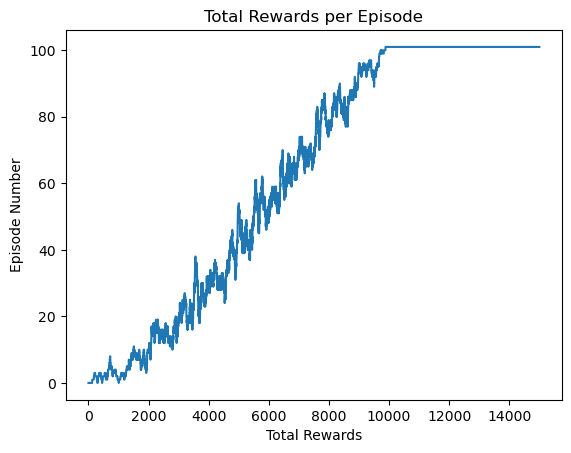

In [5]:
# do the training and see rewards
n_episodes = 15000
train(n_episodes, slippery=False)

In [6]:
# see how the little guy does!
test(render=True, slippery=False)

# Slippery

Note: acts funky sometimes when run on same kernel as non-slip - would recommend restarting the kernel, running the setup section, and then skipping the non-slip section and coming directly here. Results will be better!

Episode 0/20000
Episode 5000/20000
Episode 10000/20000
Episode 15000/20000


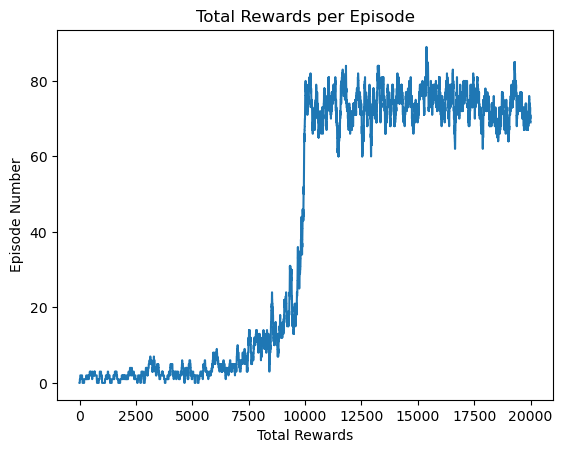

In [7]:
# do the training and see rewards
n_episodes = 20000
train(n_episodes, slippery=True)

In [9]:
# see how the little guy does!
test(render=True, slippery=True)